## Stackexchange Politics: Political Forum Network Analysis

<img src="./pickle_dataframes/networks (1).jpeg" width="50%" height="50%">

### Library Imports

In [13]:
from bs4 import BeautifulSoup
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from gensim.models import CoherenceModel
from networkx.algorithms.community import greedy_modularity_communities
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter

import community as community_louvain
import dask.dataframe as dd
import gensim
import gensim.corpora as corpora
import html
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import numpy as np
import pandas as pd
import pickle 
import pickle as pkl
import psutil
import re
import seaborn as sns
import time

pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 200
simplefilter(action='ignore', category=FutureWarning)

## Section Overview
- Typecasting
- Topic Modeling
- Sentiment Analysis
- Clustering
- Network Construction
- Community Analysis

## Typecasting

In [18]:
# Load and merge dataframes
comments = pd.concat([pd.read_pickle('./pickle_dataframes/comments1.pkl'),
                      pd.read_pickle('./pickle_dataframes/comments2.pkl')]).reset_index(drop=True)

posts = pd.concat([pd.read_pickle('./pickle_dataframes/posts1.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts2.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts3.pkl')]).reset_index(drop=True)

users = pd.read_pickle('./pickle_dataframes/users.pkl')
postlinks = pd.read_pickle('./pickle_dataframes/posts_links.pkl')
tags = pd.read_pickle('./pickle_dataframes/tags.pkl')

In [19]:
comments = comments.astype({
    'Id': 'int32',
    'PostId': 'int32',
    'Score': 'int16',
    'Text': 'object',
    'CreationDate': 'datetime64[ns]',
    'UserId': 'int32'
})

In [20]:
posts = posts.astype({
    'Id': 'int32',
    'PostTypeId': 'int32',
    'ParentId': 'int32',
    'AcceptedAnswerId': 'int16',
    'CreationDate': 'datetime64[ns]',
    'Score': 'int16',
    'ViewCount': 'int32',
    'Body': 'object',
    'OwnerUserId': 'int32',
    'LastActivityDate': 'datetime64[ns]',
    'Title': 'string',
    'Tags': 'string',
    'AnswerCount': 'int16',
    'CommentCount': 'int16'
    #'FavoriteCount': 'int16'
})

In [21]:
users = users.astype({
    'Id': 'int32',
    'Reputation': 'int32',
    'CreationDate': 'datetime64[ns]',
    'LastAccessDate': 'datetime64[ns]',
    'Views': 'int32',
    'UpVotes': 'int32',
    'DownVotes': 'int32',
})

In [22]:
postlinks = postlinks.astype({
    'Id': 'int32',
    'CreationDate': 'datetime64[ns]',
    'PostId': 'int32',
    'RelatedPostId': 'int32',
    'LinkTypeId': 'uint8'
})

In [23]:
tags = tags.astype({
    'Id': 'int32',
    'TagName': 'string',
    'Count': 'int32'
})

### Save all DataFrames to pickles

In [24]:
# "comments" and "posts" are too big

#df_comments_1, df_comments_2 = np.array_split(df_comments, 2)
#df_posts_1, df_posts_2, df_posts_3 = np.array_split(df_posts, 3)

# df_comments_1.to_pickle('comments1.pkl')
# df_comments_2.to_pickle('comments2.pkl')

# df_posts_1.to_pickle('posts1.pkl')
# df_posts_2.to_pickle('posts2.pkl')
# df_posts_3.to_pickle('posts3.pkl')
# 
# df_posts_links.to_pickle('posts_links.pkl')
# df_tags.to_pickle('tags.pkl')
# df_users.to_pickle('users.pkl')

## Topic Extraction

In [25]:
# Load and merge dataframes
comments = pd.concat([pd.read_pickle('./pickle_dataframes/comments1.pkl'),
                      pd.read_pickle('./pickle_dataframes/comments2.pkl')]).reset_index(drop=True)

posts = pd.concat([pd.read_pickle('./pickle_dataframes/posts1.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts2.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts3.pkl')]).reset_index(drop=True)

users = pd.read_pickle('./pickle_dataframes/users.pkl')
postlinks = pd.read_pickle('./pickle_dataframes/posts_links.pkl')
tags = pd.read_pickle('./pickle_dataframes/tags.pkl')

questions = posts[posts.PostTypeId==1]
answers = posts[posts['PostTypeId'] == 2]

From running various tests we found that the topic modelling method that yielded the best highest coherence score and the lowest perplexity score was:   

In [26]:
# Modify preprocess_text function
def preprocess_text(text, remove_stopwords=False, use_lemmatize=True):
    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

    words = text.split()
    if remove_stopwords:
        words = [word for word in words if word not in stopwords.words('english')]
    if use_lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)
    
    return text

In [ ]:
# Define apply_lda_and_log function with run_name parameter
def apply_topic_modeling_and_log(df, remove_stopwords, use_lemmatize, tags_weighting, run_name, ngram_range=(1, 1), max_features=1000):

    # Initialize dictionaries to store topic distributions
    lda_distributions = {}
    nmf_distributions = {}

    # Preprocess Title, Body, and Tags
    df['Title'] = df['Title'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize))
    df['Body'] = df['Body'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize))
    df['Tags'] = df['Tags'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize))


    # Combine Title, Body, and Tags with specified weight for Tags
    # We Keep the original order (title, body, tags) as it reflects the natural flow of information
    df['CombinedText'] = df['Title'] + ' ' + df['Body'] + ' ' + (df['Tags'] * tags_weighting)

    # Create a Dictionary and Corpus needed for Topic Modeling
    words = [doc.split() for doc in df['CombinedText']]
    id2word = corpora.Dictionary(words)
    corpus = [id2word.doc2bow(text) for text in words]

    # Apply TF-IDF with the specified max_features
    # ngram_range=(1, 2) for bi-grams, (1, 3) for tri-grams, and (2, 2) for only bi-grams
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['CombinedText'])

    # Apply LDA and NMF for different numbers of topics
    # Prepare a structured dictionary to store results with n_topics as part of the key
    all_topics_results = {}
    for n_topics in [10, 15, 20, 25]:
        
        # LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
        lda.fit(tfidf_matrix)

        # Extract Topic Distributions for LDA
        lda_topic_distributions = lda.transform(tfidf_matrix)

        # Normalize LDA Topic Distributions
        lda_normalized = np.array(lda_topic_distributions) / np.sum(lda_topic_distributions, axis=1)[:, None]

        # Calculate Coherence Score
        lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=0)
        coherence_model_lda = CoherenceModel(model=lda_gensim, texts=words, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()

        # Calculate LDA Perplexity
        lda_perplexity = lda.perplexity(tfidf_matrix)

        # Extract and log the top words for each topic as a table
        feature_names = tfidf_vectorizer.get_feature_names_out()
        top_words_data = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
            top_words_data.append([f"Topic {topic_idx}"] + top_words)

        # NMF
        nmf_model = NMF(n_components=n_topics, random_state=0)
        nmf_W = nmf_model.fit_transform(tfidf_matrix)

        # Normalize NMF Topic Distributions (nmf_W is already the topic distribution matrix)
        nmf_normalized = np.array(nmf_W) / np.sum(nmf_W, axis=1)[:, None]

        nmf_H = nmf_model.components_

        # Calculate NMF Reconstruction Error
        nmf_reconstruction_error = np.linalg.norm(tfidf_matrix - nmf_W.dot(nmf_H))

        # Log the top words for each topic for NMF
        nmf_top_words_data = []
        for topic_idx, topic in enumerate(nmf_H):
            top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
            nmf_top_words_data.append([f"Topic {topic_idx}"] + top_words)


        # Store the results including perplexity and reconstruction error
        all_topics_results[f"{run_name}_n_topics_{n_topics}"] = {
            'lda_normalized': lda_normalized,
            'nmf_normalized': nmf_normalized,
            'lda_coherence': coherence_lda,
            'lda_perplexity': lda_perplexity,
            'nmf_reconstruction_error': nmf_reconstruction_error,
            'lda_top_words': top_words_data,
            'nmf_top_words': nmf_top_words_data
        }
        
    # Return the topic distributions
    return all_topics_results

### You want to jump straight to the topic modelled DataFrames, don't you?
**Jump to the subsection:** Assign Topic to every comment

In [ ]:
# Test various combinations
use_lemmatize_options = [True]
tags_weighting_options = [1, 2, 5]
ngram_range_options = [(1, 1), (1, 2), (1, 3)]
max_features_options = [1000]
remove_stopwords = True 

all_results = {}

for use_lemmatize, tags_weighting, ngram_range, max_features in itertools.product(use_lemmatize_options, tags_weighting_options, ngram_range_options, max_features_options):
    run_name = f"Run_remove_{remove_stopwords}_lemmatize_{use_lemmatize}_weight_{tags_weighting}_ngram_{ngram_range}_maxfeat_{max_features}"

    topics_results = apply_topic_modeling_and_log(
        questions,
        remove_stopwords,
        use_lemmatize,
        tags_weighting, 
        run_name, 
        ngram_range, 
        max_features
    )
    print(run_name)
    all_results.update(topics_results)

# save dictionary to person_data.pkl file
with open('./pickle_dataframes/all_results.pkl', 'wb') as fp:
    pickle.dump(all_results, fp)

### Find best topic modelling technique + parameters

In [ ]:
all_results = pd.read_pickle('./pickle_dataframes/all_results.pkl')

import heapq

# Initialize min-heaps to track the top 5 best scores and parameters for LDA and NMF
top_5_lda = []
top_5_nmf = []

# Iterate through all results
for run_name, results in all_results.items():
    # Extract LDA and NMF scores
    lda_score = (results['lda_coherence'], -results['lda_perplexity'])  # Negative perplexity for min-heap
    nmf_score = -results['nmf_reconstruction_error']  # Negative error for min-heap

    # Update top 5 LDA
    if len(top_5_lda) < 5 or lda_score > top_5_lda[0][0]:
        if len(top_5_lda) == 5:
            heapq.heappop(top_5_lda)
        heapq.heappush(top_5_lda, (lda_score, run_name))

    # Update top 5 NMF
    if len(top_5_nmf) < 5 or nmf_score > top_5_nmf[0][0]:
        if len(top_5_nmf) == 5:
            heapq.heappop(top_5_nmf)
        heapq.heappush(top_5_nmf, (nmf_score, run_name))

# Output top 5 LDA
print("Top 5 LDA:")
for score, params in sorted(top_5_lda, reverse=True):
    print(f"Parameters: {params}, Coherence: {score[0]}, Perplexity: {-score[1]}")

# Output top 5 NMF
print("\nTop 5 NMF:")
for score, params in sorted(top_5_nmf, reverse=True):
    print(f"Parameters: {params}, Reconstruction Error: {-score}")

### Run the best topic model
- Parameters: Run_remove_True_lemmatize_True_weight_2_ngram_(1, 3)_maxfeat_1000_n_topics_20, Coherence: 0.4828223717706496, Perplexity: 1705.171976733514


In [ ]:
remove_stopwords = True
use_lemmatize = True 
tags_weighting = 5
ngram_range = (1, 2)
max_features = 1000
n_topics = 25

# Apply preprocessing to each column
questions['Title'] = questions['Title'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize))
questions['Body'] = questions['Body'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize))
questions['Tags'] = questions['Tags'].apply(lambda x: preprocess_text(x, remove_stopwords, use_lemmatize))

# Combine Title, Body, and Tags
questions['CombinedText'] = questions['Title'] + ' ' + questions['Body'] + ' ' + (questions['Tags'] * tags_weighting)

In [ ]:
# Apply TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
tfidf_matrix = tfidf_vectorizer.fit_transform(questions['CombinedText'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(tfidf_matrix)

# Assign topics to questions
topic_assignments = lda.transform(tfidf_matrix)

### Assign Topic to every question

In [ ]:
questions['Topic'] = topic_assignments.argmax(axis=1)
questions.shape

### Assign Topic to every answer

In [ ]:
topics_df = questions[['Id', 'Topic']]

# Merge to assign topics from questions to their answers
answers_with_topics = answers.merge(topics_df, left_on='ParentId', right_on='Id', how='left')

# Rename the 'Topic' column to something like 'InheritedTopic' to avoid confusion
answers_with_topics.rename(columns={'Topic': 'AnswerTopic'}, inplace=True)
answers_with_topics.shape

### Assign Topic to every comment

In [ ]:
# How many comments do we have?
comments.shape

In [27]:
questions = pd.read_pickle('./pickle_dataframes/questions_with_topics.pkl')
answers = pd.read_pickle('./pickle_dataframes/answers_with_topics.pkl')
topics_df = questions[['Id', 'Topic']]

In [28]:
# Merge to assign topics from questions to their answers
answers_with_topics = answers.merge(questions[['Id', 'Topic']], left_on='ParentId', right_on='Id', how='left')
answers_with_topics.rename(columns={'Topic': 'AnswerTopic'}, inplace=True)

# Create sets for faster lookup
unique_question_ids = set(questions['Id'].unique())
unique_answer_ids = set(answers_with_topics['Id_x'].unique())

In [29]:
# Assign topics to comments
# Check if the comment is associated with a question
question_comments = comments[comments['PostId'].isin(unique_question_ids)]
question_comments = question_comments.merge(questions[['Id', 'Topic']], left_on='PostId', right_on='Id', how='left')

# Check if the comment is associated with an answer
answer_comments = comments[comments['PostId'].isin(unique_answer_ids)]
answer_comments = answer_comments.merge(answers_with_topics[['Id_x', 'AnswerTopic']], left_on='PostId', right_on='Id_x', how='left')

In [30]:
# Merge and select relevant columns for question comments
question_comments_with_topics = question_comments.merge(questions[['Id', 'Topic']], left_on='PostId', right_on='Id', how='left')
question_comments_with_topics = question_comments_with_topics[['Id_x', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId', 'Topic_x']]
question_comments_with_topics.rename(columns={'Id_x': 'Id', 'Topic_x': 'CommentTopic'}, inplace=True)

In [31]:
# Merge and select relevant columns for answer comments
answer_comments_with_topics = answer_comments.merge(answers_with_topics[['Id_x', 'AnswerTopic']], left_on='PostId', right_on='Id_x', how='left')
answer_comments_with_topics = answer_comments_with_topics[['Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId', 'AnswerTopic_x']]
answer_comments_with_topics = answer_comments_with_topics.iloc[:, :7]
answer_comments_with_topics.rename(columns={'Id_x': 'Id', 'AnswerTopic_x': 'CommentTopic'}, inplace=True)

In [32]:
# Concatenate question and answer comments
all_comments_with_topics = pd.concat([question_comments_with_topics, answer_comments_with_topics], ignore_index=True)
all_comments_with_topics.head()

,Id,PostId,Score,Text,CreationDate,UserId,CommentTopic
0,1,1,9,Is it fair to inquire about the disadvantages ...,2012-12-04 22:00:00.933,28,7
1,3,1,3,"I could have reformulated the question, but at...",2012-12-04 22:02:37.737,18,7
2,7,2,2,Source on this? I don't see how it could possi...,2012-12-04 22:10:10.070,45,21
3,13,2,1,@Nick122 In a parliamentary system like the No...,2012-12-04 22:14:33.463,43,21
4,15,2,0,"Yes, but you will give a negative vote by voti...",2012-12-04 22:16:29.437,45,21


In [33]:
all_comments_with_topics.CommentTopic.value_counts().sum()

# Only 50 columns did not have either a corresponding question or answer
# Let's see which comments it was
comments_without_question_or_answer = comments[~comments['PostId'].isin(unique_question_ids) & ~comments['PostId'].isin(unique_answer_ids)]
comments_without_question_or_answer.PostId.unique()

array([57392, 57473, 57486, 57489, 57504, 57585, 75788, 75865, 75880])

In [34]:
# Printing this we see that the posts do not exist and that's why their comments could not inherit a topic
posts[posts['Id'].isin(comments_without_question_or_answer.PostId.unique())]

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount


### Save the Results to picklefiles

In [ ]:
# Save the posts dataframe with topic assignments
#questions.to_pickle('./pickle_dataframes/questions_with_topics.pkl')
#answers_with_topics.to_pickle('./pickle_dataframes/answers_with_topics.pkl')
#all_comments_with_topics.to_pickle('./pickle_dataframes/comments_with_topics.pkl')

## Sentiment Analysis

In [35]:
# Read the data
posts = pd.concat([pd.read_pickle('./pickle_dataframes/posts1.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts2.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts3.pkl')]).reset_index(drop=True)

questions = pd.read_pickle('./pickle_dataframes/questions_with_topics.pkl')
answers = pd.read_pickle('./pickle_dataframes/answers_with_topics.pkl')
comments = pd.read_pickle('./pickle_dataframes/comments_with_topics.pkl')

users = pd.read_pickle('./pickle_dataframes/users.pkl')

### Filter Users on Min. Activity

In [36]:
# Calculate user activity counts
question_count = questions.groupby('OwnerUserId').size().rename('QuestionCount')
answer_count = answers.groupby('OwnerUserId').size().rename('AnswerCount')
comment_count = comments.groupby('UserId').size().rename('CommentCount')

In [37]:
# Merge activity counts with user data
user_activity = users.merge(question_count, left_on='Id',  right_index=True, how='left') \
                     .merge(answer_count, left_on='Id', right_index=True, how='left') \
                     .merge(comment_count, left_on='Id', right_index=True, how='left') \
                     .fillna({'QuestionCount': 0, 'AnswerCount': 0, 'CommentCount': 0})

# Identify and process active users
active_users = user_activity.assign(TotalActivity=lambda x: x['QuestionCount'] + x['AnswerCount'] + x['CommentCount'])
active_users = active_users[active_users['TotalActivity'] >= 15]
active_user_ids = set(active_users['Id'])
print(f"Active users: {active_users.shape[0]}")

Active users: 1464


In [38]:
active_questions = questions[questions['OwnerUserId'].isin(active_user_ids)]
active_answers = answers[answers['OwnerUserId'].isin(active_user_ids)]
active_comments = comments[comments['UserId'].isin(active_user_ids)]

print("Active Users' Questions: ", active_questions.shape[0])
print("Active Users' Answers: ", active_answers.shape[0])
print("Active Users' Comments: ", active_comments.shape[0])

#active_posts = pd.concat([active_questions, active_answers]).drop_duplicates()
#print("Active Users' posts: ", active_posts.shape[0])

Active Users' Questions:  11435
Active Users' Answers:  31672
Active Users' Comments:  167141


Now that we have gathered all questions, answers, and comments from Active users, we proceed to our sentiment analysis. 

If you don't to run the preprocessing, skip straight to the sentiment analysis where we read the preprocessed dataframes from pickle files.

### Preprocess text
**You can save some time here** by jumping to Sentiment Analysis Time and reading the pickle files

In [39]:
# Modify preprocess_text function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>|[^a-zA-Z0-9]', ' ', text.lower())
    words = [WordNetLemmatizer().lemmatize(word) for word in text.split() if word not in stopwords.words('english')]
    text = ' '.join(words)

    return text

In [ ]:
# Questions
ddf_questions = dd.from_pandas(active_questions, npartitions=8)
ddf_questions['Body_Processed'] = ddf_questions['Body'].map_partitions(lambda df: df.apply(preprocess_text))
ddf_questions['Title_Processed'] = ddf_questions['Title'].map_partitions(lambda df: df.apply(preprocess_text))
questions_processed = ddf_questions.compute()

In [ ]:
# Answers
ddf_answers = dd.from_pandas(active_answers, npartitions=8)
ddf_answers['Body_Processed'] = ddf_answers['Body'].map_partitions(lambda df: df.apply(preprocess_text))
answers_processed = ddf_answers.compute()

In [ ]:
# Apply preprocessing
# Comments
ddf_comments = dd.from_pandas(active_comments, npartitions=8)
ddf_comments['Text_Processed'] = ddf_comments['Text'].map_partitions(lambda df: df.apply(preprocess_text))
comments_processed = ddf_comments.compute()

In [ ]:
# Save pre processed dataframes
# questions_processed.to_pickle('./pickle_dataframes/questions_preprocessed.pkl')
# answers_processed1, answers_processed2 = np.array_split(answers_processed, 2)
# 
# #answers_processed.to_pickle('./pickle_dataframes/answers_preprocessed.pkl')
# answers_processed1.to_pickle('./pickle_dataframes/answers_preprocessed1.pkl')
# answers_processed2.to_pickle('./pickle_dataframes/answers_preprocessed2.pkl')
# 
# comments_processed.to_pickle('./pickle_dataframes/comments_preprocessed.pkl')

### Sentiment Analysis Time

In [40]:
# Read in the preprocessed dataframes (answers df is split because of size)

questions_processed = pd.read_pickle('./pickle_dataframes/questions_preprocessed.pkl')
answers_processed = pd.concat([pd.read_pickle('./pickle_dataframes/answers_preprocessed1.pkl'),
                   pd.read_pickle('./pickle_dataframes/answers_preprocessed2.pkl')]).reset_index(drop=True)
comments_processed = pd.read_pickle('./pickle_dataframes/comments_preprocessed.pkl')

In [41]:
print(questions_processed.shape[0])
print(answers_processed.shape[0])
print(comments_processed.shape[0])

11435
31672
167141


In [43]:
nltk.download('vader_lexicon')
# Initialize SentimentIntensityAnalyzer once
sia = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis
def analyze_sentiment(text):
    # Check if the text is missing or NaN, return 0.0 in such cases
    if pd.isna(text):
        return 0.0
    # Ensure the text is encoded as a string
    text = str(text)
    return sia.polarity_scores(text)['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pih\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# # Convert pandas DataFrame to Dask DataFrame
questions_dask = dd.from_pandas(questions_processed, npartitions=8)  # Adjust npartitions based on available memory
answers_dask = dd.from_pandas(answers_processed, npartitions=8) 
comments_dask = dd.from_pandas(comments_processed, npartitions=8)  

# Apply sentiment analysis to questions, answers and comments
questions_dask['BodySentiment'] = questions_dask['Body'].map(analyze_sentiment)
questions_dask['TitleSentiment'] = questions_dask['Title'].map(analyze_sentiment)

answers_dask['BodySentiment'] = answers_dask['Body'].map(analyze_sentiment)

comments_dask['TextSentiment'] = comments_dask['Text'].map(analyze_sentiment)

# Compute results with progress bar
with ProgressBar():
    questions_result = questions_dask.compute()
    answers_result = answers_dask.compute()
    comments_result = comments_dask.compute()

[########################################] | 100% Completed | 5.06 sms
[########################################] | 100% Completed | 46.80 ss
[########################################] | 100% Completed | 34.46 ss


In [ ]:
# Save dataframes with sentiment to pickle

# answers_result = answers_result.drop(columns=['Id_y'])
# answers_result.rename(columns={'Id_x': 'Id'}, inplace=True)
# 
# questions_result.to_pickle('./pickle_dataframes/questions_with_sentiment.pkl')
# 
# answers_result1, answers_result2 = np.array_split(answers_result, 2)
# answers_result1.to_pickle('./pickle_dataframes/answers_with_sentiment1.pkl')
# answers_result2.to_pickle('./pickle_dataframes/answers_with_sentiment2.pkl')
# 
# 
# comments_result.to_pickle('./pickle_dataframes/comments_with_sentiment.pkl')

In [44]:
questions_with_sentiment = pd.read_pickle('./pickle_dataframes/questions_with_sentiment.pkl')
answers_with_sentiment = pd.concat([pd.read_pickle('./pickle_dataframes/answers_with_sentiment1.pkl'), pd.read_pickle('./pickle_dataframes/answers_with_sentiment2.pkl')]).reset_index(drop=True)
comments_with_sentiment = pd.read_pickle('./pickle_dataframes/comments_with_sentiment.pkl')

### Assign Attributes to Users
1. Sentiment Attributes
2. Score Attributes
3. Accepted Answer Attributes
4. Topic Engagement Normalized Vector

#### Sentiment Attributes

In [45]:
# Calculate average sentiment for questions, answers, and comments (per user)

# Questions
avg_question_body_sentiment = questions_with_sentiment.groupby('OwnerUserId')['BodySentiment'].mean().rename('AvgQuestionBodySentiment')
avg_question_title_sentiment = questions_with_sentiment.groupby('OwnerUserId')['TitleSentiment'].mean().rename('AvgQuestionTitleSentiment')

# Answers
avg_answer_body_sentiment = answers_with_sentiment.groupby('OwnerUserId')['BodySentiment'].mean().rename('AvgAnswerSentiment')

# Comments
avg_comment_sentiment = comments_with_sentiment.groupby('UserId')['TextSentiment'].mean().rename('AvgCommentSentiment')

In [46]:
# Merge avg_question_body_sentiment onto active_users dataframe
users_with_sentiments = active_users.merge(avg_question_body_sentiment, left_on='Id', right_index=True, how='left')

# Merge avg_question_title_sentiment
users_with_sentiments = users_with_sentiments.merge(avg_question_title_sentiment, left_on='Id', right_index=True, how='left')

# Merge avg_answer_body_sentiment
users_with_sentiments = users_with_sentiments.merge(avg_answer_body_sentiment, left_on='Id', right_index=True, how='left')

# Merge avg_comment_sentiment
users_with_sentiments = users_with_sentiments.merge(avg_comment_sentiment, left_on='Id', right_index=True, how='left')

# Fill the ~1300 missing sentiment values with 0
users_with_sentiments.fillna(0, inplace=True)

users_with_sentiments.head(2)

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,TotalActivity,AvgQuestionBodySentiment,AvgQuestionTitleSentiment,AvgAnswerSentiment,AvgCommentSentiment
0,-1,1,2012-12-04 20:12:06.337,2012-12-04 20:12:06.337,267,5442,6725,881.0,1320.0,8879.0,11080.0,0.182188,0.013791,0.178233,0.085863
5,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,0.0,3.0,31.0,34.0,0.000000,0.000000,0.185433,0.469406


#### Score Attributes

In [47]:
# Calculate average scores

# Average Question Score
avg_question_score = questions_with_sentiment.groupby('OwnerUserId')['Score'].mean().rename('AvgQuestionScore')

# Average Answer Score
avg_answer_score = answers_with_sentiment.groupby('OwnerUserId')['Score'].mean().rename('AvgAnswerScore')

# Average Comment Score
avg_comment_score = comments_with_sentiment.groupby('UserId')['Score'].mean().rename('AvgCommentScore')

In [48]:
users_with_sentiments_and_scores = users_with_sentiments.merge(avg_question_score, left_on='Id', right_index=True, how='left')
users_with_sentiments_and_scores = users_with_sentiments_and_scores.merge(avg_answer_score, left_on='Id', right_index=True, how='left')
users_with_sentiments_and_scores = users_with_sentiments_and_scores.merge(avg_comment_score, left_on='Id', right_index=True, how='left')

users_with_sentiments_and_scores.head(2)

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,TotalActivity,AvgQuestionBodySentiment,AvgQuestionTitleSentiment,AvgAnswerSentiment,AvgCommentSentiment,AvgQuestionScore,AvgAnswerScore,AvgCommentScore
0,-1,1,2012-12-04 20:12:06.337,2012-12-04 20:12:06.337,267,5442,6725,881.0,1320.0,8879.0,11080.0,0.182188,0.013791,0.178233,0.085863,6.820658,7.738636,1.578669
5,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,0.0,3.0,31.0,34.0,0.000000,0.000000,0.185433,0.469406,NaN,7.000000,1.193548


### Accepted Answer Attributes

In [49]:
accepted_answers = set(questions_with_sentiment[questions_with_sentiment['OwnerUserId'] > -1]['AcceptedAnswerId'])
accepted_answers_count = answers_with_sentiment[answers_with_sentiment['Id'].isin(accepted_answers)].groupby('OwnerUserId').size().rename('AcceptedAnswerCount')
accepted_answers_count

OwnerUserId
-1        135
 5          1
 8          7
 18        10
 23        44
         ... 
 20709      2
 20713      1
 21385      1
 21620      1
 46665      2
Name: AcceptedAnswerCount, Length: 326, dtype: int64

In [50]:
users_with_attributes = users_with_sentiments_and_scores.merge(accepted_answers_count, left_on='Id', right_index=True, how='left')
users_with_attributes['AcceptedAnswerFraction'] = users_with_attributes['AcceptedAnswerCount'] / users_with_attributes['AnswerCount']
users_with_attributes.head()

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,TotalActivity,AvgQuestionBodySentiment,AvgQuestionTitleSentiment,AvgAnswerSentiment,AvgCommentSentiment,AvgQuestionScore,AvgAnswerScore,AvgCommentScore,AcceptedAnswerCount,AcceptedAnswerFraction
0,-1,1,2012-12-04 20:12:06.337,2012-12-04 20:12:06.337,267,5442,6725,881.0,1320.0,8879.0,11080.0,0.182188,0.013791,0.178233,0.085863,6.820658,7.738636,1.578669,135.0,0.102273
5,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,0.0,3.0,31.0,34.0,0.000000,0.000000,0.185433,0.469406,NaN,7.000000,1.193548,1.0,0.333333
8,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,0.0,13.0,10.0,23.0,0.000000,0.000000,0.689277,0.049030,NaN,20.230769,1.500000,7.0,0.538462
18,18,5325,2012-12-04 21:37:27.683,2013-12-18 15:57:41.670,427,110,11,16.0,20.0,65.0,101.0,0.661300,0.212294,0.287115,0.189645,13.562500,13.700000,0.769231,10.0,0.500000
23,23,16227,2012-12-04 21:49:39.360,2015-02-14 02:38:09.917,1449,803,54,36.0,124.0,277.0,437.0,0.381967,0.141828,0.374322,0.199965,13.361111,7.782258,1.321300,44.0,0.354839


### Topic distribution attribute (topic modelling vector)

- Combine the DataFrames
- Aggregate Topics per User
- One-Hot Encode Topics
- Normalize the Topic Engagement: For each user, normalize their topic participation so that the sum across all topic columns equals 1. This represents the proportion of their participation in each topic.

In [51]:
questions_topic_distribution_vector = questions_with_sentiment[['OwnerUserId', 'Topic']].copy()
answers_topic_distribution_vector = answers_with_sentiment[['OwnerUserId', 'AnswerTopic']].copy()
comments_topic_distribution_vector = comments_with_sentiment[['UserId', 'CommentTopic']].copy()

questions_topic_distribution_vector['UserId'] = questions_topic_distribution_vector['OwnerUserId']
answers_topic_distribution_vector['UserId'] = answers_topic_distribution_vector['OwnerUserId']
answers_topic_distribution_vector['Topic'] = answers_topic_distribution_vector['AnswerTopic']
comments_topic_distribution_vector['Topic'] = comments_topic_distribution_vector['CommentTopic']

questions_topic_distribution_vector.head(2)

,OwnerUserId,Topic,UserId
0,18,7,18
4,18,21,18


In [52]:
combined_topic_distribution_df = pd.concat([
    questions_topic_distribution_vector[['UserId', 'Topic']],
    answers_topic_distribution_vector[['UserId', 'Topic']],
    comments_topic_distribution_vector[['UserId', 'Topic']]
])

combined_topic_distribution_df = combined_topic_distribution_df[combined_topic_distribution_df['UserId'] != -1]

In [53]:
# Step 1: One-Hot Encoding
one_hot_encoded_topics = pd.get_dummies(combined_topic_distribution_df['Topic'])
one_hot_encoded_topics

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
25,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
26,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
42,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184613,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
184614,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
184615,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
184618,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [54]:
# Add UserId back for aggregation
one_hot_encoded_topics['UserId'] = combined_topic_distribution_df['UserId']
one_hot_encoded_topics.head(2)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,UserId
0,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,18
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,18


In [55]:
# Step 2: Aggregation
user_topic_engagement = one_hot_encoded_topics.groupby('UserId').sum()
user_topic_engagement

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
UserId,,,,,,,,,,,,,,,,,,,,,
5,0,7,0,8,0,0,0,0,7,1,...,0,0,1,1,0,0,2,0,0,6
8,0,0,0,3,4,0,0,4,0,0,...,0,0,0,0,0,0,9,0,0,2
18,0,6,0,10,3,1,0,4,8,2,...,0,0,2,0,0,0,30,4,0,24
23,8,66,0,78,33,8,0,19,55,0,...,0,7,7,19,0,1,42,2,4,53
26,0,1,0,1,0,0,0,4,1,0,...,0,0,0,0,0,0,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,14
46253,0,1,0,0,0,0,0,0,2,0,...,0,0,0,0,1,0,0,0,0,12
46524,6,0,0,2,0,0,1,0,0,3,...,0,0,0,0,0,0,5,0,0,6


In [56]:
# Step 3: Normalization
user_topic_engagement_normalized = user_topic_engagement.div(user_topic_engagement.sum(axis=1), axis=0)
user_topic_engagement_normalized

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
UserId,,,,,,,,,,,,,,,,,,,,,
5,0.000000,0.205882,0.0,0.235294,0.000000,0.000000,0.000000,0.000000,0.205882,0.029412,...,0.000000,0.000000,0.029412,0.029412,0.000000,0.000000,0.058824,0.000000,0.000000,0.176471
8,0.000000,0.000000,0.0,0.130435,0.173913,0.000000,0.000000,0.173913,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.391304,0.000000,0.000000,0.086957
18,0.000000,0.059406,0.0,0.099010,0.029703,0.009901,0.000000,0.039604,0.079208,0.019802,...,0.000000,0.000000,0.019802,0.000000,0.000000,0.000000,0.297030,0.039604,0.000000,0.237624
23,0.018307,0.151030,0.0,0.178490,0.075515,0.018307,0.000000,0.043478,0.125858,0.000000,...,0.000000,0.016018,0.016018,0.043478,0.000000,0.002288,0.096110,0.004577,0.009153,0.121281
26,0.000000,0.066667,0.0,0.066667,0.000000,0.000000,0.000000,0.266667,0.066667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266667,0.000000,0.000000,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46025,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.777778
46253,0.000000,0.062500,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.750000
46524,0.260870,0.000000,0.0,0.086957,0.000000,0.000000,0.043478,0.000000,0.000000,0.130435,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217391,0.000000,0.000000,0.260870


In [57]:
# Step 4: Preparation for Clustering
user_topic_engagement_normalized['MostEngagedTopic'] = user_topic_engagement_normalized.idxmax(axis=1)
user_topic_distribution = user_topic_engagement_normalized.reset_index()
user_topic_distribution

,UserId,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,MostEngagedTopic
0,5,0.000000,0.205882,0.0,0.235294,0.000000,0.000000,0.000000,0.000000,0.205882,...,0.000000,0.029412,0.029412,0.000000,0.000000,0.058824,0.000000,0.000000,0.176471,3
1,8,0.000000,0.000000,0.0,0.130435,0.173913,0.000000,0.000000,0.173913,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.391304,0.000000,0.000000,0.086957,21
2,18,0.000000,0.059406,0.0,0.099010,0.029703,0.009901,0.000000,0.039604,0.079208,...,0.000000,0.019802,0.000000,0.000000,0.000000,0.297030,0.039604,0.000000,0.237624,21
3,23,0.018307,0.151030,0.0,0.178490,0.075515,0.018307,0.000000,0.043478,0.125858,...,0.016018,0.016018,0.043478,0.000000,0.002288,0.096110,0.004577,0.009153,0.121281,3
4,26,0.000000,0.066667,0.0,0.066667,0.000000,0.000000,0.000000,0.266667,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.266667,0.000000,0.000000,0.066667,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,46025,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.777778,24
1459,46253,0.000000,0.062500,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,...,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.750000,24
1460,46524,0.260870,0.000000,0.0,0.086957,0.000000,0.000000,0.043478,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.217391,0.000000,0.000000,0.260870,0
1461,46665,0.052632,0.052632,0.0,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.210526,0.000000,0.000000,0.210526,14


In [58]:
users_with_all_attributes = users_with_attributes.merge(user_topic_distribution, left_on='Id', right_on='UserId', how='left')
users_with_all_attributes = users_with_all_attributes[users_with_all_attributes['Id'] != -1]
users_with_all_attributes = users_with_all_attributes.drop(columns='UserId')
users_with_all_attributes.head(2)

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,...,16,17,18,19,20,21,22,23,24,MostEngagedTopic
1,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,0.0,3.0,31.0,...,0.0,0.029412,0.029412,0.0,0.0,0.058824,0.0,0.0,0.176471,3.0
2,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,0.0,13.0,10.0,...,0.0,0.000000,0.000000,0.0,0.0,0.391304,0.0,0.0,0.086957,21.0


### Save Results

In [59]:
#users_with_all_attributes.to_pickle('./pickle_dataframes/users_with_all_attributes.pkl')
users_with_all_attributes = pd.read_pickle('./pickle_dataframes/users_with_all_attributes.pkl')
users_with_all_attributes.head()

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,...,16,17,18,19,20,21,22,23,24,MostEngagedTopic
1,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,0.0,3.0,31.0,...,0.000000,0.029412,0.029412,0.0,0.000000,0.058824,0.000000,0.000000,0.176471,3.0
2,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,0.0,13.0,10.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.391304,0.000000,0.000000,0.086957,21.0
3,18,5325,2012-12-04 21:37:27.683,2013-12-18 15:57:41.670,427,110,11,16.0,20.0,65.0,...,0.000000,0.019802,0.000000,0.0,0.000000,0.297030,0.039604,0.000000,0.237624,21.0
4,23,16227,2012-12-04 21:49:39.360,2015-02-14 02:38:09.917,1449,803,54,36.0,124.0,277.0,...,0.016018,0.016018,0.043478,0.0,0.002288,0.096110,0.004577,0.009153,0.121281,3.0
5,26,1794,2012-12-04 21:52:54.060,2020-11-19 03:57:56.387,24,34,3,1.0,7.0,7.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.266667,0.000000,0.000000,0.066667,7.0


## Network Creation

In [60]:
# Read the data
posts = pd.concat([pd.read_pickle('./pickle_dataframes/posts1.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts2.pkl'),
                   pd.read_pickle('./pickle_dataframes/posts3.pkl')]).reset_index(drop=True)

questions = pd.read_pickle('./pickle_dataframes/questions_with_topics.pkl')
answers = pd.read_pickle('./pickle_dataframes/answers_with_topics.pkl')
comments = pd.read_pickle('./pickle_dataframes/comments_with_topics.pkl')

users = pd.read_pickle('./pickle_dataframes/users.pkl')

### Filter Users on Min. Activity

In [61]:
# Calculate user activity counts
question_count = questions.groupby('OwnerUserId').size().rename('QuestionCount')
answer_count = answers.groupby('OwnerUserId').size().rename('AnswerCount')
comment_count = comments.groupby('UserId').size().rename('CommentCount')

In [62]:
# Merge activity counts with user data
user_activity = users.merge(question_count, left_on='Id',  right_index=True, how='left') \
                     .merge(answer_count, left_on='Id', right_index=True, how='left') \
                     .merge(comment_count, left_on='Id', right_index=True, how='left') \
                     .fillna({'QuestionCount': 0, 'AnswerCount': 0, 'CommentCount': 0})

# Identify and process active users
active_users = user_activity.assign(TotalActivity=lambda x: x['QuestionCount'] + x['AnswerCount'] + x['CommentCount'])
active_users = active_users[active_users['TotalActivity'] >= 15]
active_user_ids = set(active_users['Id'])
print(f"Active users: {active_users.shape[0]}")

Active users: 1464


In [63]:
active_questions = questions[questions['OwnerUserId'].isin(active_user_ids)]
active_answers = answers[answers['OwnerUserId'].isin(active_user_ids)]
active_comments = comments[comments['UserId'].isin(active_user_ids)]

print("Active Users' Questions: ", active_questions.shape[0])
print("Active Users' Answers: ", active_answers.shape[0])
print("Active Users' Comments: ", active_comments.shape[0])

#active_posts = pd.concat([active_questions, active_answers]).drop_duplicates()
#print("Active Users' posts: ", active_posts.shape[0])

Active Users' Questions:  11435
Active Users' Answers:  31672
Active Users' Comments:  167141


Now that we have gathered all questions, answers, and comments from Active users, we proceed to our sentiment analysis. 

If you don't to run the preprocessing, skip straight to the sentiment analysis where we read the preprocessed dataframes from pickle files.

### Preprocess text

In [64]:
# Modify preprocess_text function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>|[^a-zA-Z0-9]', ' ', text.lower())
    words = [WordNetLemmatizer().lemmatize(word) for word in text.split() if word not in stopwords.words('english')]
    text = ' '.join(words)

    return text

In [65]:
# Questions
ddf_questions = dd.from_pandas(active_questions, npartitions=8)
ddf_questions['Body_Processed'] = ddf_questions['Body'].map_partitions(lambda df: df.apply(preprocess_text))
ddf_questions['Title_Processed'] = ddf_questions['Title'].map_partitions(lambda df: df.apply(preprocess_text))
questions_processed = ddf_questions.compute()

In [ ]:
# Answers
ddf_answers = dd.from_pandas(active_answers, npartitions=8)
ddf_answers['Body_Processed'] = ddf_answers['Body'].map_partitions(lambda df: df.apply(preprocess_text))
answers_processed = ddf_answers.compute()

In [ ]:
# Apply preprocessing
# Comments
ddf_comments = dd.from_pandas(active_comments, npartitions=8)
ddf_comments['Text_Processed'] = ddf_comments['Text'].map_partitions(lambda df: df.apply(preprocess_text))
comments_processed = ddf_comments.compute()

In [ ]:
# Save pre processed dataframes
# questions_processed.to_pickle('./pickle_dataframes/questions_preprocessed.pkl')
# answers_processed1, answers_processed2 = np.array_split(answers_processed, 2)
# 
# #answers_processed.to_pickle('./pickle_dataframes/answers_preprocessed.pkl')
# answers_processed1.to_pickle('./pickle_dataframes/answers_preprocessed1.pkl')
# answers_processed2.to_pickle('./pickle_dataframes/answers_preprocessed2.pkl')
# 
# comments_processed.to_pickle('./pickle_dataframes/comments_preprocessed.pkl')

In [67]:
# Read in the preprocessed dataframes (answers df is split because of size)

questions_processed = pd.read_pickle('./pickle_dataframes/questions_preprocessed.pkl')
answers_processed = pd.concat([pd.read_pickle('./pickle_dataframes/answers_preprocessed1.pkl'),
                   pd.read_pickle('./pickle_dataframes/answers_preprocessed2.pkl')]).reset_index(drop=True)
comments_processed = pd.read_pickle('./pickle_dataframes/comments_preprocessed.pkl')

In [68]:
print(questions_processed.shape[0])
print(answers_processed.shape[0])
print(comments_processed.shape[0])

11435
31672
167141


### Network Generation [1:2]: The DataFrame

In [69]:
# Read the data
questions = pd.read_pickle('./pickle_dataframes/questions_with_sentiment.pkl')
answers = pd.concat([pd.read_pickle('./pickle_dataframes/answers_with_sentiment1.pkl'), 
                     pd.read_pickle('./pickle_dataframes/answers_with_sentiment2.pkl')]).reset_index(drop=True)
comments = pd.read_pickle('./pickle_dataframes/comments_with_sentiment.pkl')

users = pd.read_pickle('./pickle_dataframes/users_with_all_attributes.pkl')

users_with_all_attributes = pd.read_pickle('./pickle_dataframes/users_with_all_attributes.pkl')
users_with_all_attributes.head(2)

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,...,16,17,18,19,20,21,22,23,24,MostEngagedTopic
1,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,0.0,3.0,31.0,...,0.0,0.029412,0.029412,0.0,0.0,0.058824,0.0,0.0,0.176471,3.0
2,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,0.0,13.0,10.0,...,0.0,0.000000,0.000000,0.0,0.0,0.391304,0.0,0.0,0.086957,21.0


In [70]:
# Preparing a list of question IDs
parent_list = questions.Id.tolist()

# Identifying Comments Associated with Questions and Answers
comments_on_questions = comments[comments['PostId'].isin(questions['Id'])]
comments_on_answers = comments[comments['PostId'].isin(answers['Id'])]

In [71]:
# Aggregating commenters by the post they commented on
comments_on_questions_agg = comments_on_questions.groupby('PostId')['UserId'].apply(list).reset_index()
comments_on_answers_agg = comments_on_answers.groupby('PostId')['UserId'].apply(list).reset_index()

In [72]:
# Mapping Answer IDs to their corresponding Question IDs
answer_to_question_map = answers.set_index('Id')['ParentId'].to_dict()
comments_on_answers_agg['MappedPostId'] = comments_on_answers_agg['PostId'].map(lambda x: answer_to_question_map.get(x, None))

# Filtering out None values which have no corresponding question
comments_on_answers_agg = comments_on_answers_agg[comments_on_answers_agg['MappedPostId'].notnull()]

In [73]:
# Creating a unified DataFrame for comment data
comments_combined = pd.concat([
    comments_on_questions_agg.rename(columns={'PostId': 'QuestionId', 'UserId': 'CommentOnQuestionUserId_list'}),
    comments_on_answers_agg.rename(columns={'MappedPostId': 'QuestionId', 'UserId': 'CommentOnAnswersUserId_list'})
], ignore_index=True)

# Replacing NaN values with empty lists
comments_combined['CommentOnQuestionUserId_list'] = comments_combined['CommentOnQuestionUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
comments_combined['CommentOnAnswersUserId_list'] = comments_combined['CommentOnAnswersUserId_list'].apply(lambda x: x if isinstance(x, list) else [])

# Grouping and combining lists
comments_combined = comments_combined.groupby('QuestionId').agg(
    CommentOnQuestionUserId_list=('CommentOnQuestionUserId_list', lambda x: sum(x, [])),
    CommentOnAnswersUserId_list=('CommentOnAnswersUserId_list', lambda x: sum(x, []))
).reset_index()

In [74]:
# Filtering answers that are related to the collected questions
df_int = answers[answers.ParentId.isin(parent_list)]

In [75]:
# Grouping answers by their parent question and aggregating answerer user IDs
df_subpost = df_int.groupby('ParentId').agg(
    answers_UserId_list=('OwnerUserId', lambda x: list(x))
).reset_index(drop=False)

In [76]:
# Identifying original posters for each question
df_original_poster = questions[questions.Id.isin(df_int.ParentId.tolist())].copy()
df_original_poster = df_original_poster.groupby('Id').agg(
    original_poster_UserId=('OwnerUserId', lambda x: list(x))
)

In [77]:
# Merging to form a comprehensive DataFrame for graph construction
df_graph = pd.merge(
    left=df_original_poster,
    right=df_subpost,
    left_on='Id',
    right_on='ParentId'
)

# Cleaning up the 'original_poster' column
df_graph['original_poster_UserId'] = df_graph['original_poster_UserId'].apply(lambda x: x[0] if x else None)

# Integrating Comment Data with the Graph Data
df_graph = pd.merge(df_graph, comments_combined, left_on='ParentId', right_on='QuestionId', how='left')

In [78]:
df_graph['CommentOnQuestionUserId_list'] = df_graph['CommentOnQuestionUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
df_graph['CommentOnAnswersUserId_list'] = df_graph['CommentOnAnswersUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
df_graph = df_graph[df_graph['original_poster_UserId'] != -1]

#### If you want to see how to get each of the values in df_graph's columns expand below rows: 

In [79]:
# displaying the different columns of row 1 manually
df_graph.head(1)

,original_poster_UserId,ParentId,answers_UserId_list,QuestionId,CommentOnQuestionUserId_list,CommentOnAnswersUserId_list
0,18,1,"[26, 8, 4666]",1.0,"[28, 18, 8018]","[7014, 9921]"


In [80]:
# We look at question 1
# We see that it belongs to questions['OwnerUserId']==18 (original_poster_UserId==18)
questions[questions['Id']==1]

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,CombinedText,Topic,Body_Processed,Title_Processed,BodySentiment,TitleSentiment
0,1,1,-1,5,2012-12-04 21:40:29.743,42,8309,know situation could arise u one candidate win...,18,2019-06-29 09:18:38.430,disadvantage first past post electoral system,,3,3,disadvantage first past post electoral system ...,7,know situation could arise u one candidate win...,disadvantage first past post electoral system,0.886,-0.4215


In [81]:
# We look at the answers to question 1
# We see that the answers['OwnerUserId'] corresponds to the users in df_graph['answers_UserId_list'] == [26, 8, 4666]	
answers[answers['ParentId']==1]

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,AnswerTopic,Body_Processed,BodySentiment
0,4,2,1,-1,2012-12-04 21:58:11.187,7,-1,<p>First-past-the-post voting tends to result ...,26,2012-12-04 21:58:11.187,Comment: N/A,Comment: N/A,-1,1,7,first past post voting tends result smaller nu...,0.9788
1,5,2,1,-1,2012-12-04 21:58:39.037,47,-1,<p>Simple plurality voting has very little in ...,8,2012-12-04 22:04:42.767,Comment: N/A,Comment: N/A,-1,1,7,simple plurality voting little favor election ...,0.9782
3077,10983,2,1,-1,2016-05-21 05:28:21.770,5,-1,<p>First-past-the-post systems are polarizing....,4666,2016-05-21 05:28:21.770,Comment: N/A,Comment: N/A,-1,0,7,first past post system polarizing advantage ta...,0.9669


In [82]:
# We look at the comments on the questions (CommentersOnQuestion)
# We see that the comments['UserId'] corresponds to the users in df_graph['CommentersOnQuestion'] == [28, 18, 8018]	
comments[comments['PostId']==1]

,Id,PostId,Score,Text,CreationDate,UserId,CommentTopic,Text_Processed,TextSentiment
0,1,1,9,Is it fair to inquire about the disadvantages ...,2012-12-04 22:00:00.933,28,7,fair inquire disadvantage without taking accou...,0.2732
1,3,1,3,"I could have reformulated the question, but at...",2012-12-04 22:02:37.737,18,7,could reformulated question least disadvantage...,0.3269
7646,36295,1,0,You may find this cat's explanation interestin...,2016-05-19 12:09:10.397,8018,7,may find cat explanation interesting http www ...,0.4019


In [83]:
# We look at the comments on the first/3 of the question answers
# We see that the comments['UserId'] corresponds to one of the user in df_graph['CommentersOnAnswers'] == [7014, 9921]	 
comments[comments['PostId']==4]

,Id,PostId,Score,Text,CreationDate,UserId,CommentTopic,Text_Processed,TextSentiment
95611,97897,4,2,The primary system used by America makes the p...,2017-12-12 04:26:11.517,7014,7,primary system used america make polarization ...,0.7906


### Network Generation [2:2]: The graph

**We have to consider how we connect** 
- original_poster_UserId to CommentOnAnswersUserId_list
- answers_UserId_list to CommentOnAnswersUserId_list

Do we connect both or only one of them?
- In `G1` we connect original_poster_UserId to CommentOnAnswersUserId_list

In a more extensive study, we would've also defined `G2` and `G3`:
- In `G2` we connect answers_UserId_list to CommentOnAnswersUserId_list
- In `G3` we connect both

In [86]:
G1 = nx.Graph()
# - original_poster_UserId to CommentOnAnswersUserId_list

# Adding nodes and edges for original posters, answerers, and commenters
for idx, row in df_graph.iterrows():
    original_poster_UserId = row['original_poster_UserId']
    G1.add_node(original_poster_UserId)

    # Add edges from original poster to answerers
    for user in row['answers_UserId_list']:
        G1.add_edge(original_poster_UserId, user)

    # Add edges from original poster to commenters on the question
    if isinstance(row['CommentOnQuestionUserId_list'], list):
        for commenter in row['CommentOnQuestionUserId_list']:
            G1.add_edge(original_poster_UserId, commenter)

    # Add edges from original poster to commenters on the answers
    if isinstance(row['CommentOnAnswersUserId_list'], list):
        for commenter in row['CommentOnAnswersUserId_list']:
            G1.add_edge(original_poster_UserId, commenter)

print(f'len(G1.nodes(): {len(G1.nodes(data=True))}')
print(f'len(G1.edges()): {len(G1.edges())}')

len(G1.nodes(): 1463
len(G1.edges()): 34693


#### For Gephi visualization purposes: Assigning Node Attributes

In [87]:
# Take the relevant attribute columns in the user dataframe
UserAttributesForNetwork=users_with_all_attributes[['Id','Reputation','Views','UpVotes','DownVotes','QuestionCount','AnswerCount','CommentCount','TotalActivity','AvgQuestionBodySentiment','AvgQuestionTitleSentiment','AvgAnswerSentiment','AvgCommentSentiment','AvgQuestionScore','AvgAnswerScore','AvgCommentScore','AcceptedAnswerCount','AcceptedAnswerFraction',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,'MostEngagedTopic']]
# Assign the nodes to the user attributes
user_attrs = UserAttributesForNetwork.set_index('Id').T.to_dict()

In [88]:
# Iterate over the user attributes dictionary and add each to the corresponding node
for user_id, attrs in user_attrs.items():
    if user_id in G1.nodes:
        nx.set_node_attributes(G1, {user_id: attrs})

# If you want to check the attributes of a specific user node, this is how you do it (you already knew that)
print(G1.nodes[5])

{'Reputation': 315.0, 'Views': 49.0, 'UpVotes': 14.0, 'DownVotes': 58.0, 'QuestionCount': 0.0, 'AnswerCount': 3.0, 'CommentCount': 31.0, 'TotalActivity': 34.0, 'AvgQuestionBodySentiment': 0.0, 'AvgQuestionTitleSentiment': 0.0, 'AvgAnswerSentiment': 0.18543333333333334, 'AvgCommentSentiment': 0.46940645161290323, 'AvgQuestionScore': nan, 'AvgAnswerScore': 7.0, 'AvgCommentScore': 1.1935483870967742, 'AcceptedAnswerCount': 1.0, 'AcceptedAnswerFraction': 0.3333333333333333, 0: 0.0, 1: 0.20588235294117646, 2: 0.0, 3: 0.23529411764705882, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.20588235294117646, 9: 0.029411764705882353, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.029411764705882353, 15: 0.0, 16: 0.0, 17: 0.029411764705882353, 18: 0.029411764705882353, 19: 0.0, 20: 0.0, 21: 0.058823529411764705, 22: 0.0, 23: 0.0, 24: 0.17647058823529413, 'MostEngagedTopic': 3.0}


In [89]:
# Save Network to Gephi
# nx.write_graphml(G1, './graphml/graph2.graphml')

To create the beutiful networks that we included in our report (and many more that we didn't have enough real estate to plot) the `graph2.graphml` file is imported into Gephi (Read more here: https://gephi.org/), Layour algorithm is chosen to "ForceAtlas2", Scaling=0.25, Gravity=1.5. You can change the colors, and display different clusters in the network by filtering partitions.

### Community Detection: Network

In [90]:
# Calculate different network statistics
avg_degree_centrality = sum(nx.degree_centrality(G1).values()) / len(G1)
avg_clustering_coefficient = nx.average_clustering(G1)
connected_components = list(nx.connected_components(G1))
avg_betweenness_centrality = sum(nx.betweenness_centrality(G1).values()) / len(G1)
communities = greedy_modularity_communities(G1)

# Analysis - You might print these or plot them using matplotlib or similar
print("Average Degree Centrality:", avg_degree_centrality)
print("Average Clustering Coefficient:", avg_clustering_coefficient)
print("Number of Connected Components:", len(connected_components))
print("Average Betweenness Centrality:", avg_betweenness_centrality)
print("Number of Communities detected:", len(communities))

Average Degree Centrality: 0.03243994827262136
Average Clustering Coefficient: 0.3731202489653536
Number of Connected Components: 1
Average Betweenness Centrality: 0.0007910656467275
Number of Communities detected: 12


In [91]:
# Detect communities
partition = community_louvain.best_partition(G1)

# Assign community label to each node
for node, community in partition.items():
    G1.nodes[node]['community'] = community

G1.nodes(data=True)
G1.nodes[node]['community'] = community

# G1.nodes(data=True)

In [92]:
# Extract Node data to dataframe
node_data = [{'UserId': node, 'Community': data['community']} for node, data in G1.nodes(data=True)]
community_df = pd.DataFrame(node_data)
community_df.Community.value_counts()

Community
0    499
3    467
2    243
1    235
5     12
4      7
Name: count, dtype: int64

We see that the Louvain Methods found 4 communities in our network.

### Community Detection: K-Means Clustering

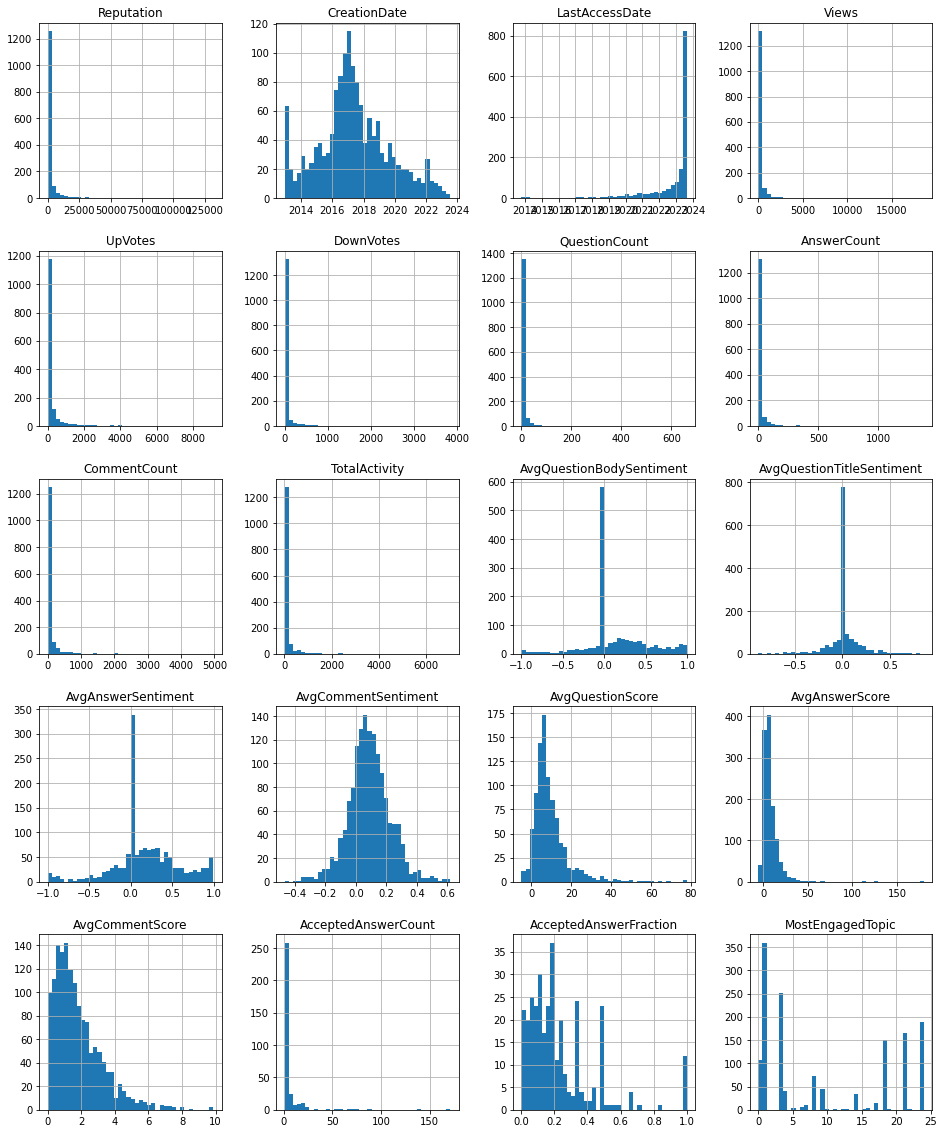

In [93]:
# Display a histogram of specified columns in the dataframe to gain insight into the data
users_with_all_attributes.iloc[:, 1:-26].join(users_with_all_attributes.iloc[:, -1]).hist(bins=40, figsize=(16, 20))  # Excludes the ID column and single-topic engagement columns

plt.show()

In [94]:
def custom_cluster(df, clustering_features, n_clusters, clustering_name, random_state=42, verbose=False, minmax=True):
    '''
    This function accepts a DataFrame, a list of features for clustering, and a clustering name. To determine 
    the optimal number of clusters, you can run the function with any value for n_clusters and set verbose to True. 
    This will generate elbow method and silhouette analysis plots. After inspecting these plots, you can rerun 
    the function with n_clusters set to the optimal number of clusters.

    When verbose is enabled, the function also provides additional plots:
    * Distributions among clusters for each of the clustering features are displayed as boxplots.
    * Lineplots illustrate per-feature normalized values across clusters for each of the clustering features. In these lineplots, 
    the cluster with the highest value for each feature is scaled to 1, the cluster with the lowest value is scaled to 0, 
    and the other clusters are plotted on a normalized scale in between. If minmax is set to False, the lineplot simply includes 
    the value of each cluster for each feature (non-normalised).
    '''
    # Impute NaNs and scale features
    features = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df[clustering_name] = kmeans.fit_predict(scaled_features)

    # Display plots
    if verbose:
        # Elbow method and silhouette analysis
        wcss, silhouette_scores = [], []
        for i in range(1, 11):
            kmeans_i = KMeans(n_clusters=i, random_state=random_state).fit(scaled_features)
            wcss.append(kmeans_i.inertia_)
            if i > 1:
                score = silhouette_score(scaled_features, kmeans_i.labels_)
                silhouette_scores.append(score)

        # Plot elbow method and silhouette analysis results
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].plot(range(1, 11), wcss)
        axs[0].set_title('Elbow Method')
        axs[0].set_xlabel('Number of Clusters')
        axs[0].set_ylabel('WCSS')
        axs[0].grid(True)

        axs[1].plot(range(2, 11), silhouette_scores)
        axs[1].set_title('Silhouette Analysis')
        axs[1].set_xlabel('Number of Clusters')
        axs[1].set_ylabel('Silhouette Score')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Plot boxplots of feature distributions
        num_features = len(clustering_features)
        num_rows = (num_features - 1) // 5 + 1
        num_cols = min(num_features, 5)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
        axs = axs.flatten() if num_features > 1 else [axs]
        for i, feature in enumerate(clustering_features):
            sns.boxplot(x=clustering_name, y=feature, data=df, ax=axs[i])
            axs[i].set(title=f'{feature} Distribution', xlabel='Cluster', ylabel='Count')
        for ax in axs[len(clustering_features):]:
            ax.set_visible(False)
        plt.tight_layout()
        plt.show()

    # Compute cluster information
    cluster_counts = df[clustering_name].value_counts().sort_index().reset_index(name='Count')
    cluster_means = df.groupby(clustering_name)[clustering_features].mean().add_suffix('Mean')
    cluster_info = pd.merge(cluster_counts, cluster_means, on=clustering_name)

    # Plot lineplot of cluster information
    if verbose:
        if minmax:  # MinMax scaling for lineplot
            minmax_scaler = MinMaxScaler()
            mean_feature_names = [f'{feature}Mean' for feature in clustering_features]
            scaled = cluster_info[mean_feature_names].apply(lambda x: minmax_scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
            scaled[clustering_name] = cluster_info[clustering_name]
            melted = scaled.melt(id_vars=[clustering_name], var_name='Feature', value_name='NormalizedValue')
            ylabel = "Per-Feature Normalised Value"
        else:  # Absolute values for lineplot
            melted = cluster_info.drop('Count', axis=1).melt(id_vars=[clustering_name], var_name='Feature', value_name='Mean')
            ylabel = "Mean Value"

        plt.figure(figsize=(10, 5))
        value_column = 'NormalizedValue' if minmax else 'Mean'
        title = "Per-Feature Normalised Values Across Clusters" if minmax else "Mean Values of Features Across Clusters"
        for cluster in melted[clustering_name].unique():
            data = melted[melted[clustering_name] == cluster]
            plt.plot(data['Feature'], data[value_column], label=f'Cluster {cluster}')
        plt.title(title)
        plt.xlabel("Feature")
        plt.ylabel(ylabel)
        plt.xticks(rotation=45)
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

    return cluster_info

In [95]:
def permutation_test_clustering(df, clustering_name, clustering_features, num_permutations=1000, verbose=False):
    '''
    This function accepts a DataFrame, a clustering name, and a list of features for clustering. It performs a permutation 
    test to assess the significance of a clustering algorithm's performance using the silhouette score.
    '''
    # Impute NaNs and scale features
    features = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Compute silhouette score using actual labels
    actual_labels = df[clustering_name].values
    actual_silhouette_score = silhouette_score(scaled_features, actual_labels)
    
    # Compute silhouette scores using permuted labels
    permuted_silhouette_scores = []
    for _ in range(num_permutations):
        shuffled_labels = np.random.permutation(actual_labels)
        permuted_silhouette_score = silhouette_score(scaled_features, shuffled_labels)
        permuted_silhouette_scores.append(permuted_silhouette_score)

    # Calculate p-value for significance testing
    p_value = (np.sum(np.array(permuted_silhouette_scores) >= actual_silhouette_score) + 1) / (num_permutations + 1)

    if verbose:
        print(f'Actual silhouette score: {actual_silhouette_score}')
        print(f'p-value: {p_value}')

    return actual_silhouette_score, p_value

### 1. Clustering by Activity Metrics
In below section, we run clustering and permutation tests on 5 different set of user attributes. After the first run, the remaining should be collapsed. This is to ease the reading of the notebook.

#### 1.1 Clustering by question count, answer count, and comment count

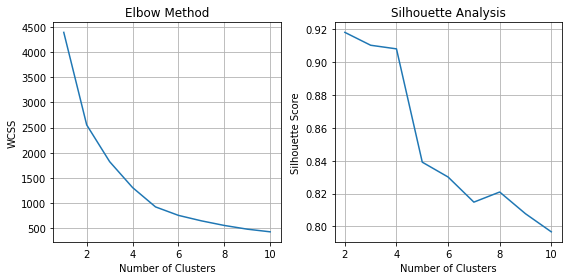

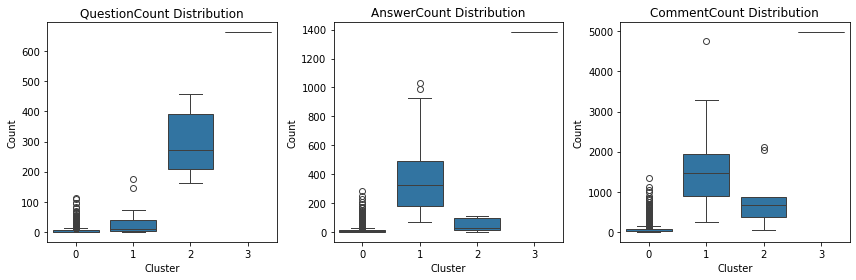

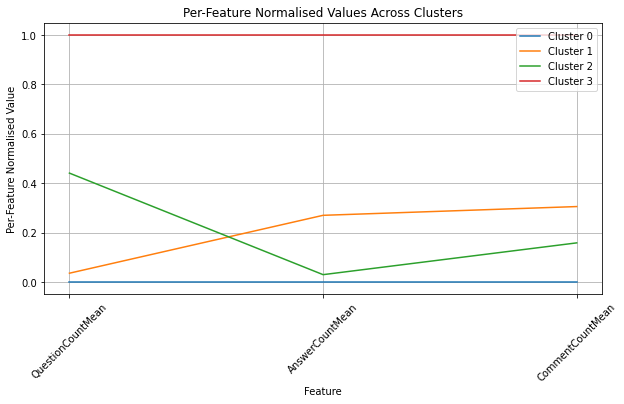

,ActivityCluster,Count,QuestionCountMean,AnswerCountMean,CommentCountMean
0,0,1424,4.517556,12.245787,70.413624
1,1,29,27.827586,381.344828,1565.896552
2,2,9,294.555556,52.666667,845.555556
3,3,1,663.000000,1381.000000,4972.000000


In [96]:
clustering_features = ['QuestionCount', 'AnswerCount', 'CommentCount']
clustering_name = 'ActivityCluster'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [97]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.9081609059757345
p-value: 0.000999000999000999


### 2. Clustering by Quality Metrics

#### 2.1 Clustering by reputation, average question score, average answer score, and average comment score

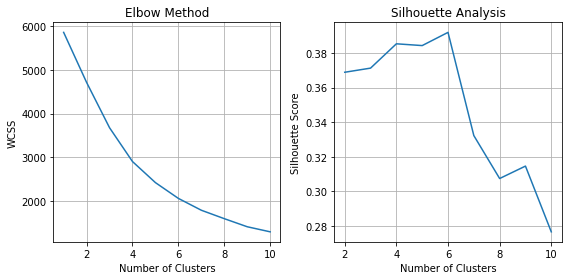

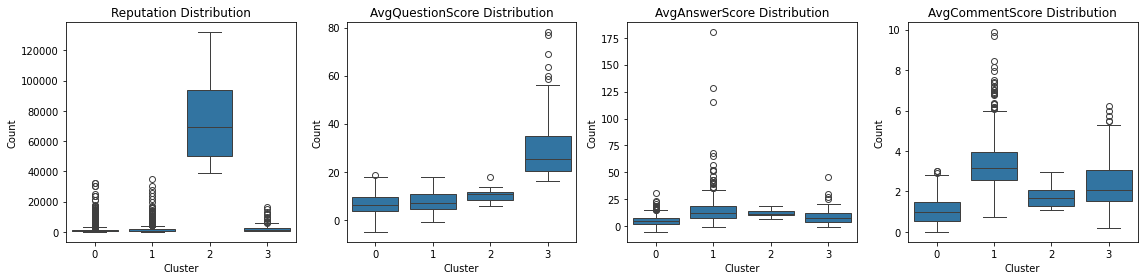

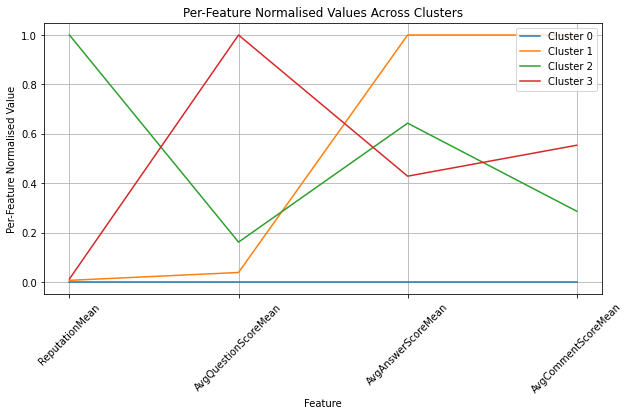

,QualityCluster1,Count,ReputationMean,AvgQuestionScoreMean,AvgAnswerScoreMean,AvgCommentScoreMean
0,0,933,1711.833869,6.682733,4.977559,1.042431
1,1,409,2223.853301,7.573918,15.665143,3.436663
2,2,16,74118.812500,10.385368,11.852085,1.729446
3,3,105,2632.095238,29.546801,9.559383,2.368631


In [98]:
clustering_features = ['Reputation', 'AvgQuestionScore', 'AvgAnswerScore', 'AvgCommentScore']
clustering_name = 'QualityCluster1'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [99]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.3853100990662119
p-value: 0.000999000999000999


#### 2.2 Clustering by accepted answer count and accepted answer fraction

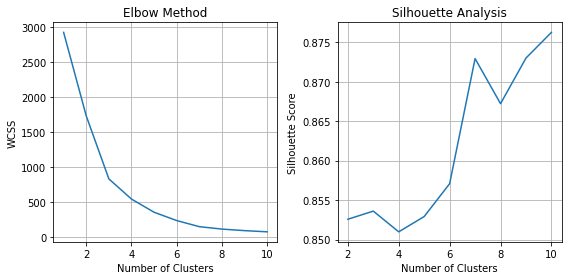

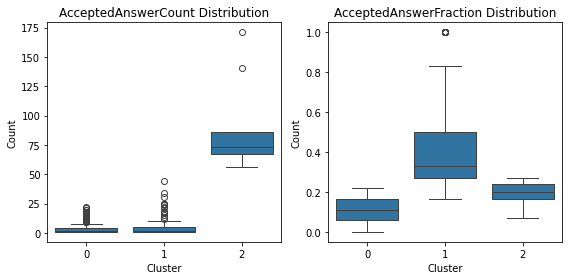

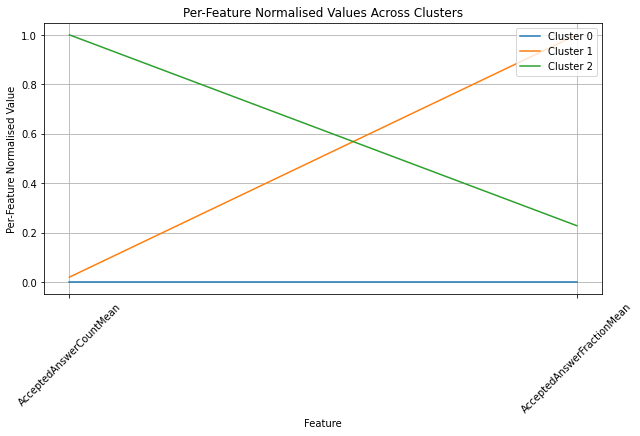

,QualityCluster2,Count,AcceptedAnswerCountMean,AcceptedAnswerFractionMean
0,0,1334,3.505102,0.112406
1,1,120,5.166667,0.440166
2,2,9,88.888889,0.187083


In [100]:
clustering_features = ['AcceptedAnswerCount', 'AcceptedAnswerFraction']
clustering_name = 'QualityCluster2'

custom_cluster(users_with_all_attributes, clustering_features, 3, clustering_name, verbose=True)

In [101]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.8535996779633784
p-value: 0.000999000999000999


### 3. Clustering by Sentiment Metrics

#### 3.1 Clustering by average question body sentiment, average question title sentiment, average answer sentiment, average comment sentiment

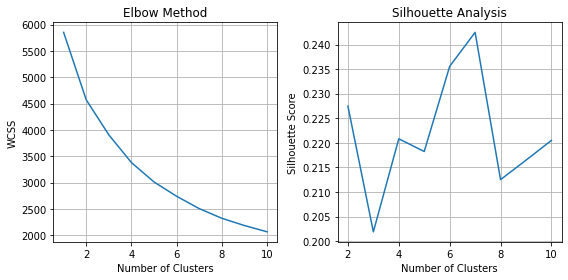

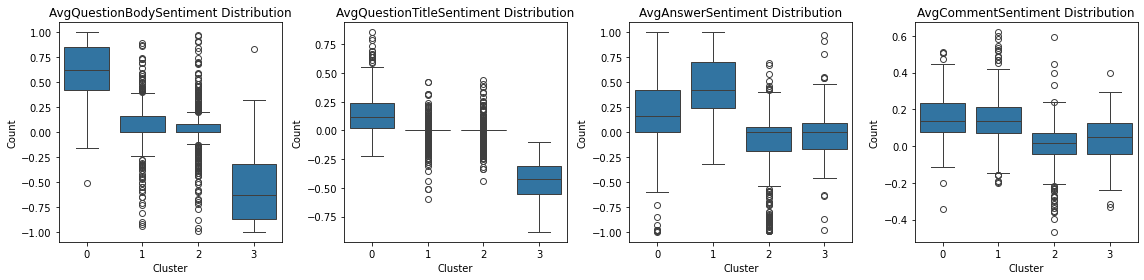

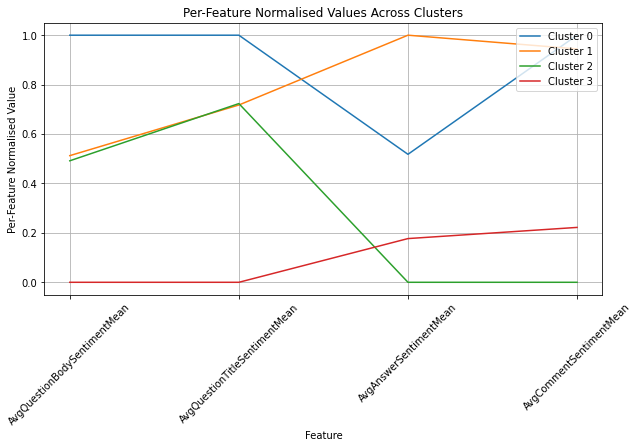

,SentimentCluster,Count,AvgQuestionBodySentimentMean,AvgQuestionTitleSentimentMean,AvgAnswerSentimentMean,AvgCommentSentimentMean
0,0,320,0.627018,0.163162,0.191663,0.152359
1,1,519,0.055159,-0.008394,0.454793,0.144190
2,2,554,0.030685,-0.004889,-0.091066,0.005242
3,3,70,-0.546127,-0.444112,0.005493,0.037914


In [102]:
clustering_features = ['AvgQuestionBodySentiment', 'AvgQuestionTitleSentiment', 'AvgAnswerSentiment', 'AvgCommentSentiment']
clustering_name = 'SentimentCluster'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [103]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.22081717570540838
p-value: 0.000999000999000999


### 4. Clustering by Engagement Metrics

#### 4.1 Clustering by views, upvotes, and downvotes

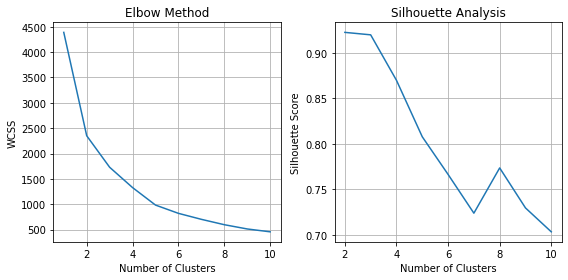

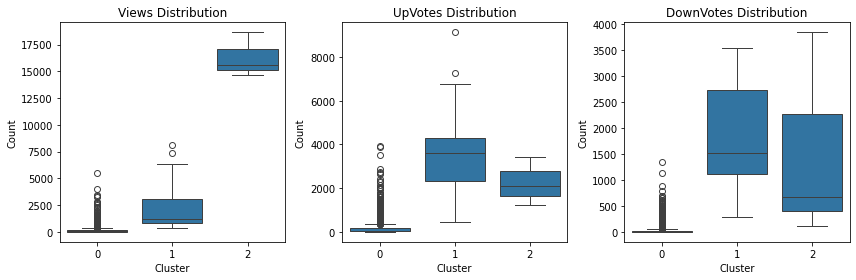

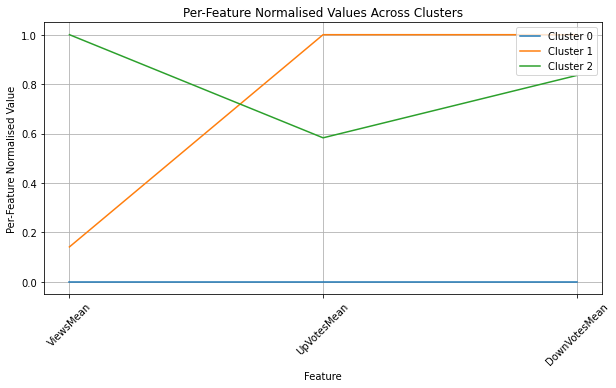

,EngagementCluster,Count,ViewsMean,UpVotesMean,DownVotesMean
0,0,1440,171.065972,179.325694,34.183333
1,1,20,2444.950000,3738.650000,1840.350000
2,2,3,16289.666667,2253.000000,1542.333333


In [104]:
clustering_features = ['Views', 'UpVotes', 'DownVotes']
clustering_name = 'EngagementCluster'

custom_cluster(users_with_all_attributes, clustering_features, 3, clustering_name, verbose=True)

In [105]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.9196770389342239
p-value: 0.000999000999000999


### 5. Clustering by Topic Engagement Metrics

#### 5.1 Clustering by topic engagement columns

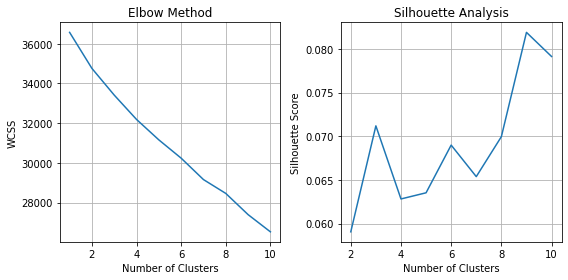

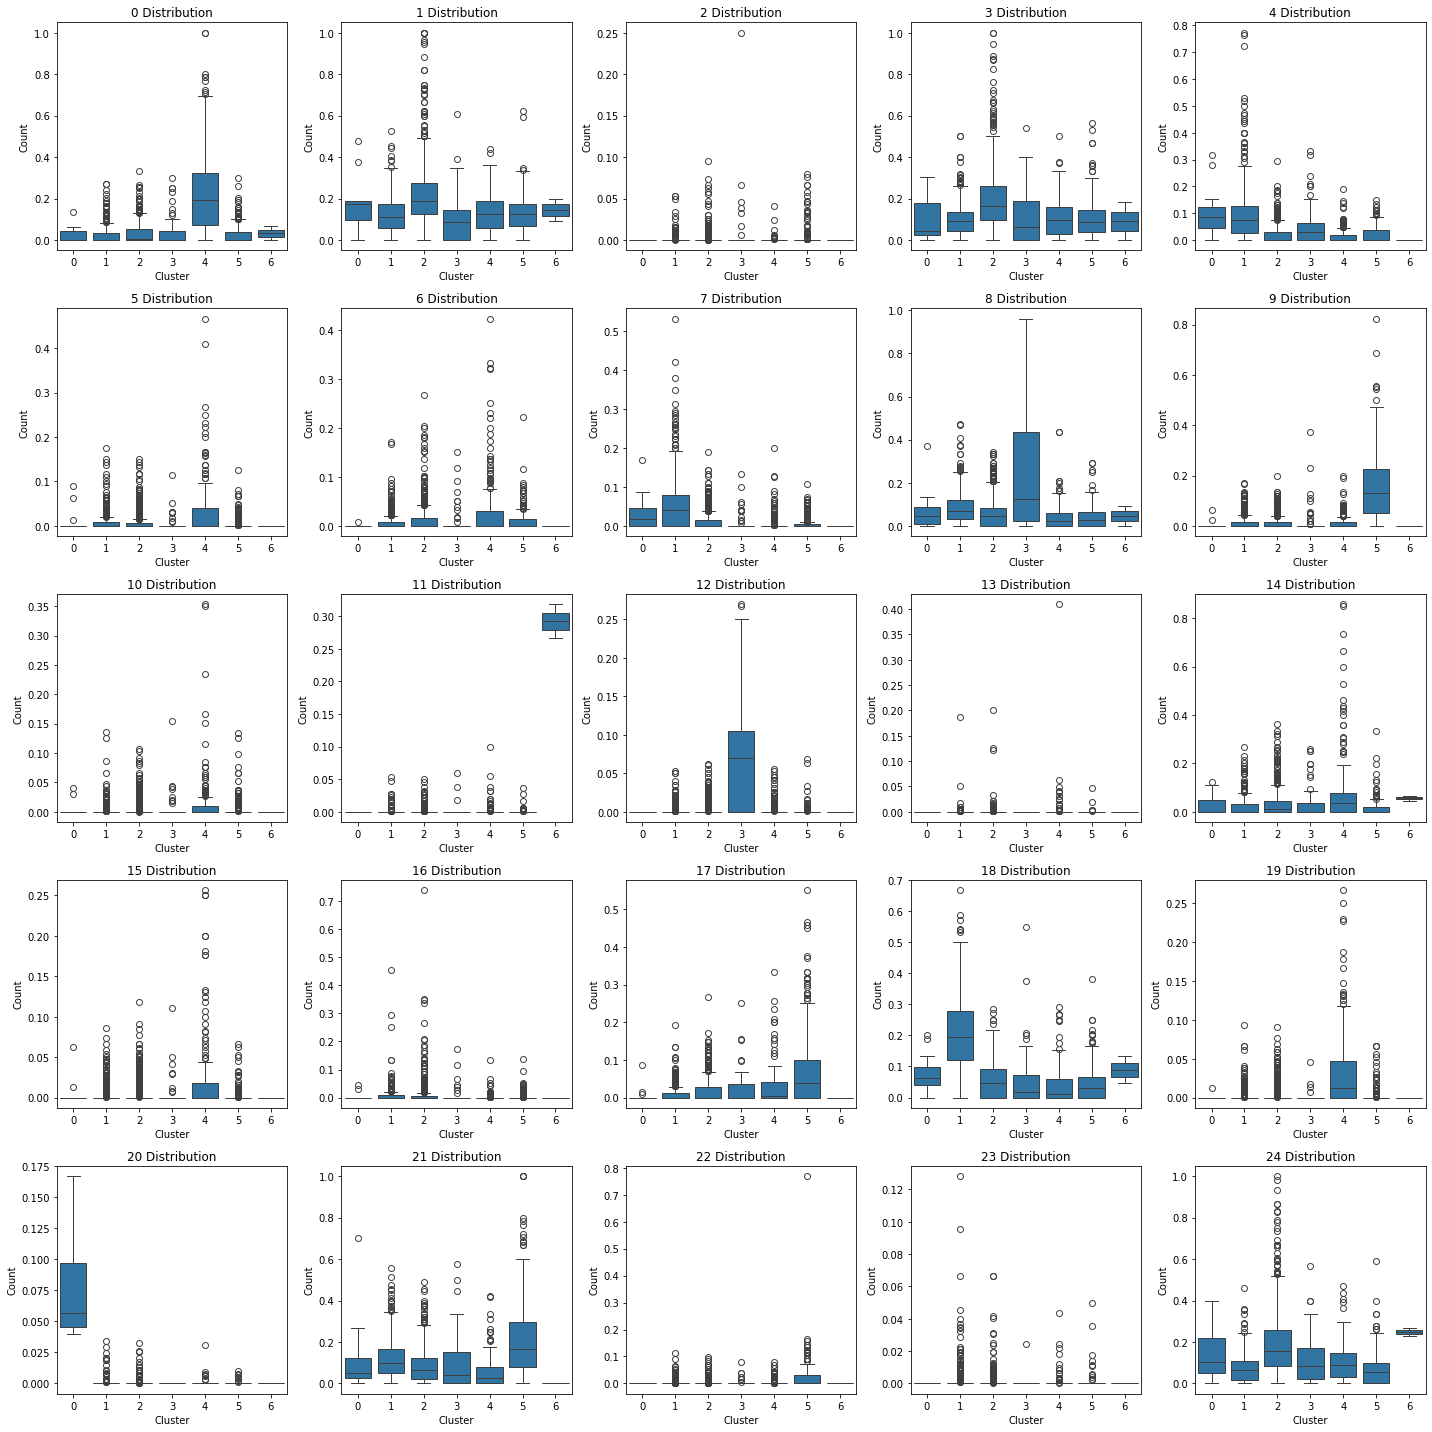

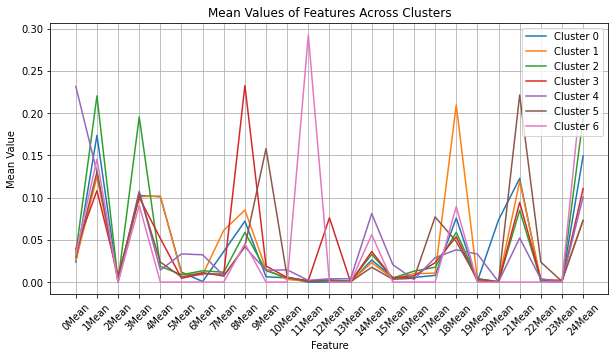

,TopicEngagementCluster,Count,0Mean,1Mean,2Mean,3Mean,4Mean,5Mean,6Mean,7Mean,...,15Mean,16Mean,17Mean,18Mean,19Mean,20Mean,21Mean,22Mean,23Mean,24Mean
0,0,14,0.023739,0.173707,0.000000,0.102506,0.100955,0.011862,0.000644,0.036273,...,0.005368,0.005445,0.007954,0.075730,0.000904,0.073574,0.122670,0.000000,0.000000,0.149212
1,1,366,0.025131,0.124517,0.001163,0.101021,0.101859,0.009769,0.008605,0.061262,...,0.004219,0.009898,0.010593,0.209629,0.003012,0.000743,0.119192,0.003030,0.002602,0.073327
2,2,617,0.034124,0.220342,0.001652,0.195542,0.018618,0.008661,0.013346,0.011709,...,0.004894,0.012914,0.017585,0.058877,0.004104,0.000423,0.084976,0.002414,0.001035,0.193844
3,3,65,0.039144,0.108243,0.007031,0.100246,0.051673,0.004559,0.009897,0.009369,...,0.004448,0.007465,0.022963,0.053701,0.001290,0.000000,0.094327,0.003421,0.000380,0.110745
4,4,202,0.231469,0.130235,0.000535,0.107629,0.014167,0.033365,0.032296,0.007681,...,0.020547,0.003138,0.028854,0.038270,0.033200,0.000326,0.052214,0.003678,0.000819,0.100731
5,5,197,0.029469,0.130442,0.004548,0.105167,0.023673,0.006125,0.011217,0.007086,...,0.003370,0.004508,0.077184,0.047902,0.003653,0.000231,0.221501,0.023709,0.000813,0.072918
6,6,2,0.033333,0.145455,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.089394,0.000000,0.000000,0.000000,0.000000,0.000000,0.246970


In [106]:
clustering_features = list(range(25))
clustering_name = 'TopicEngagementCluster'

custom_cluster(users_with_all_attributes, clustering_features, 7, clustering_name, verbose=True, minmax=False)

In [107]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.06538506756729
p-value: 0.000999000999000999


#### For Gephi visualization purposes: Assigning Node Attributes
As mentioned earlier, Gephi let's you visualize nodes attributes in a very intuitive way.

In [108]:
UserAttributesForNetwork = users_with_all_attributes[['Id', 'MostEngagedTopic', 'EngagementCluster', 'ActivityCluster', 'QualityCluster1', 'QualityCluster2', 'SentimentCluster', 'EngagementCluster', 'TopicEngagementCluster']]
user_attrs = UserAttributesForNetwork.set_index('Id').T.to_dict()
# Iterate over the user attributes dictionary and add each to the corresponding node
for user_id, attrs in user_attrs.items():
    if user_id in G1.nodes:
        nx.set_node_attributes(G1, {user_id: attrs})

# Save Network to Gephi
# nx.write_graphml(G1, './graphml/graph2.graphml')

### Results
To scope down our results section a bit we choose to compare our network communities with the two cluster approaches displayed in the report (and in the banner of this notebook if that works on your end). The one that visually looked well partitioned: `TopicEngagementCluster`, and the one that analytically was well partitioned: `QualityCluster1`.

#### Clusters vs. Communities

In [109]:
# Merge the dataframes on the user ID
combined_df = pd.merge(users_with_all_attributes, community_df, left_on='Id', right_on='UserId')

# Now, we check for consistent grouping in both community and clustering
consistent_grouping = combined_df.groupby(['Community', 'QualityCluster1'])['Id'].nunique().reset_index()

# Rename columns for clarity
consistent_grouping.rename(columns={'Id': 'UniqueUsersCount'}, inplace=True)

# Display the result
print(consistent_grouping)

    Community  QualityCluster1  UniqueUsersCount
0           0                0               364
1           0                1                99
2           0                2                 4
3           0                3                31
4           1                0               131
5           1                1                86
6           1                2                 1
7           1                3                17
8           2                0               133
9           2                1                80
10          2                2                 4
11          2                3                26
12          3                0               290
13          3                1               141
14          3                2                 7
15          3                3                29
16          4                0                 4
17          4                1                 1
18          4                3                 2
19          5       

In [110]:
# Now, we check for consistent grouping in both community and clustering
consistent_grouping = combined_df.groupby(['Community', 'TopicEngagementCluster'])['Id'].nunique().reset_index()

# Rename columns for clarity
consistent_grouping.rename(columns={'Id': 'UniqueUsersCount'}, inplace=True)

# Display the result
print(consistent_grouping)

    Community  TopicEngagementCluster  UniqueUsersCount
0           0                       0                 4
1           0                       1               136
2           0                       2               241
3           0                       3                28
4           0                       4                51
5           0                       5                37
6           0                       6                 1
7           1                       0                 8
8           1                       1               127
9           1                       2                67
10          1                       3                14
11          1                       4                 7
12          1                       5                12
13          2                       0                 1
14          2                       1                34
15          2                       2                72
16          2                       3           

#### User Attribute Analysis

The cross tabulation shows how many users in a particular community (e.g., Community 0) fall into a specific cluster first in QualityCluster1 and then in TopicEngagementCluster.

For example in the first, we see that 269 users in Community == 0 are also in QualityCluster1 == 0. This might imply that the attributes defining Cluster 0 are prevalent in Community 0. On the other hand, low numbers indicate combinations where community membership and clustering attributes do not align as much. For instance, only 3 users in Community 0 fall into Cluster 2. Similarly, the results of the second tabulation looks even more random.

We will still have a look at a few attributes of significant combinations

In [111]:
combined_df.columns

Index([                       'Id',                'Reputation',
                    'CreationDate',            'LastAccessDate',
                           'Views',                   'UpVotes',
                       'DownVotes',             'QuestionCount',
                     'AnswerCount',              'CommentCount',
                   'TotalActivity',  'AvgQuestionBodySentiment',
       'AvgQuestionTitleSentiment',        'AvgAnswerSentiment',
             'AvgCommentSentiment',          'AvgQuestionScore',
                  'AvgAnswerScore',           'AvgCommentScore',
             'AcceptedAnswerCount',    'AcceptedAnswerFraction',
                                 0,                           1,
                                 2,                           3,
                                 4,                           5,
                                 6,                           7,
                                 8,                           9,
                         

In [112]:
# Filter for users in both Community 0 and Cluster 0
community0_cluster0_df = combined_df[(combined_df['Community'] == 0) & (combined_df['QualityCluster1'] == 0)]

# Select a subset of columns for analysis
columns_of_interest = ['Reputation', 'UpVotes', 'DownVotes', 'QuestionCount', 'AnswerCount', 
                       'CommentCount', 'TotalActivity', 'AvgQuestionScore', 'AvgAnswerScore', 'AvgCommentScore', 'AvgQuestionBodySentiment', 'AvgQuestionTitleSentiment','AvgAnswerSentiment']

# Get descriptive statistics for these columns
overview_stats = community0_cluster0_df[columns_of_interest].describe()
overview_stats

,Reputation,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,TotalActivity,AvgQuestionScore,AvgAnswerScore,AvgCommentScore,AvgQuestionBodySentiment,AvgQuestionTitleSentiment,AvgAnswerSentiment
count,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,283.000000,311.000000,364.000000,364.000000,364.000000,364.000000
mean,1904.439560,194.717033,50.873626,7.225275,18.123626,99.236264,124.585165,6.761314,4.747450,0.954602,0.165178,0.005426,0.167815
std,3651.037913,661.167275,213.686675,14.637731,44.119530,275.240669,314.179163,4.231858,3.866893,0.589432,0.394845,0.194858,0.391773
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,15.000000,-5.000000,-5.250000,0.000000,-0.990600,-0.877900,-0.985200
25%,332.500000,10.000000,0.750000,1.000000,2.000000,15.000000,21.000000,4.000000,2.000000,0.500000,0.000000,-0.014866,0.000000
50%,703.000000,33.000000,4.000000,3.000000,5.000000,26.000000,35.000000,6.166667,4.307692,0.910214,0.153100,0.000000,0.113125
75%,1583.500000,110.250000,18.250000,7.000000,12.000000,64.000000,87.750000,9.000000,7.245798,1.354298,0.402625,0.066168,0.403546
max,30376.000000,9131.000000,2629.000000,162.000000,382.000000,3281.000000,3464.000000,18.833333,19.000000,3.000000,0.985000,0.855500,0.992100


#### What can we see here? 
- The mean values for UpVotes, DownVotes, QuestionCount, AnswerCount, and CommentCount suggest a moderately active user base. There is however large standard deviation.
- The average reputation of 1885 indicates that these users are relatively established on the forum. However, the large standard deviation (3729) suggests a wide range of reputations within this group
- The average scores for questions, answers, and comments (6.67, 4.99, and 0.95 respectively) indicate generally positive contributions from these users. 
- Activity varies a lot
- Sentiment Scores are close to neutral (sentiment = 0) but has large standard deviation

### Thank you for reading!